# Aperture photometry for mock images

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.colors import LogNorm      
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

## Import detector image and convert unit
Data used in this notebook can be found here: https://polybox.ethz.ch/index.php/s/Ydf1Ixy9IyCTl4x

In [2]:
from astropy import units as u
from astropy import constants as const
D = 6.5 * u.m
QE = 0.9
gain = 2.05
lam_ref = 2 * u.um
dlam = 0.457 * u.um
E_ph = const.h * const.c / lam_ref.to(u.m)
Jy2SI = (1 * u.Jy).to(u.J * u.s**-1 * u.m**-2 * u.um**-1, equivalencies=u.spectral_density(2* u.um))
Jy2ADU = (Jy2SI / E_ph) * np.pi*(D/2)**2 * dlam * QE * (1 / gain)
print("1 Jy at {0:5.2f} corresponds to {1:5.2f}".format(lam_ref, Jy2ADU))

1 Jy at  2.00 um corresponds to 50238355.87 1 / s


In [3]:
fname = "jw00005001001_01101_00001_nis_linear.fits"
with fits.open(fname) as hdulist:
    img = hdulist['SCI'].data
    hdr = hdulist[0].header
print(img.shape)
extent = (xmin, xmax, ymin, ymax) = (1007, 1039, 1007, 1039)

(1, 10, 2048, 2048)


2.406446e-07 0.01593466


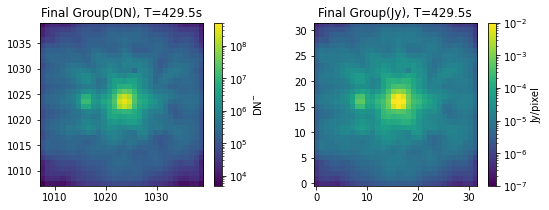

In [5]:
# convert flux unit to Jy/pixel
t_int = hdr["EFFEXPTM"]
fluxJy = img[0, 9, ymin:ymax, xmin:xmax] / t_int / Jy2ADU.value
fluxwide = img[0, 9, ymin-30:ymax+30, xmin-30:xmax+30] / t_int / Jy2ADU.value

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

im1 = ax1.imshow(img[0, 9, ymin:ymax, xmin:xmax], extent=extent, norm=LogNorm(vmin=5e3,vmax=5e8), origin="lower")
ax1.set_title('Final Group(DN), T=429.5s')
fig.colorbar(im1, ax=ax1).set_label('DN$^{-}$')

im2 = ax2.imshow(fluxJy, norm=LogNorm(vmin=1e-7,vmax=1e-2), origin="lower")
ax2.set_title('Final Group(Jy), T=429.5s')
fig.colorbar(im2, ax=ax2).set_label('Jy/pixel')

print(fluxJy.min(), fluxJy.max())
imgsize = fluxJy.shape[0]

## Estimate aperture sizes

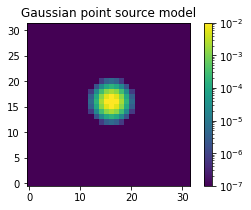

In [6]:
# define 2D Gaussian model
from astropy.modeling import models
g2d = models.Gaussian2D()
flux = np.zeros((imgsize,imgsize))
for x in range(imgsize):
    for y in range(imgsize):
        flux[x,y] = g2d.evaluate(x, y, amplitude=fluxJy.max(), 
        x_mean=imgsize/2, y_mean=imgsize/2, x_stddev=1, y_stddev=1, theta=0)
plt.figure(figsize=(5,3))
plt.imshow(flux, norm=LogNorm(vmin=1e-7,vmax=1e-2), origin="lower")
plt.colorbar()
plt.title("Gaussian point source model")
plt.show()

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
         amplitude            x_mean       ...      y_stddev            theta       
    ------------------- ------------------ ... ------------------ ------------------
    0.01612907810087339 16.012858768882186 ... 0.9123994281567923 2.2688851731073454
FWHM_star = 2.1243853827010177


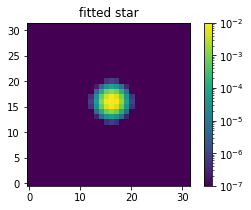

In [7]:
# estimate star FWHM
from astropy.modeling import fitting
fit_g = fitting.LevMarLSQFitter()
#x, y = range(imgsize)
y, x = np.mgrid[:imgsize, :imgsize]
fitted_star = fit_g(g2d, x, y, fluxJy)
plt.figure(figsize=(5,3))
plt.imshow(fitted_star(x, y), norm=LogNorm(vmin=1e-7,vmax=1e-2), origin="lower")
plt.colorbar()
plt.title("fitted star")
print(fitted_star)
FWHM_star = 2.0 * np.sqrt(2.0 * np.log(2.0)) * fitted_star.x_stddev
print("FWHM_star =",FWHM_star)

FWHM_star = 2.1243853827010177


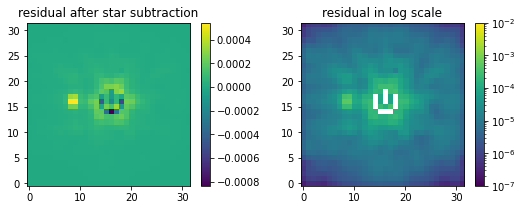

In [8]:
# residual from Gaussian star
res = fluxJy - fitted_star(x, y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
im1 = ax1.imshow(res, origin="lower")
ax1.set_title("residual after star subtraction")

im2 = ax2.imshow(res, norm=LogNorm(vmin=1e-7,vmax=1e-2), origin="lower")
ax2.set_title("residual in log scale")
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

FWHM_star = 2.0 * np.sqrt(2.0 * np.log(2.0)) * fitted_star.x_stddev
print("FWHM_star =",FWHM_star)

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
          amplitude             x_mean      ...        theta       
    --------------------- ----------------- ... -------------------
    0.0006397337773829751 8.551505029183206 ... -1.6826110578719242
FWHM_CPD = 2.2263688605700667


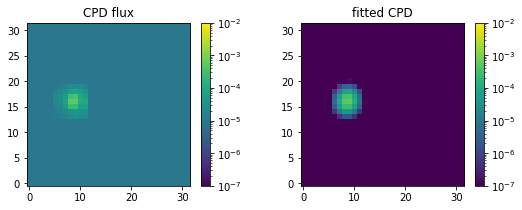

In [9]:
# estimate FWHM of CPD
fluxCPD = np.ones((imgsize,imgsize)) * np.median(res)
fluxCPD[13:20,5:12] = res[13:20,5:12]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
im1 = ax1.imshow(fluxCPD,norm=LogNorm(vmin=1e-7,vmax=1e-2), origin="lower")
fig.colorbar(im1, ax=ax1)
ax1.set_title("CPD flux")

fitted_CPD = fit_g(g2d, x, y, fluxCPD)
im2 = ax2.imshow(fitted_CPD(x, y), norm=LogNorm(vmin=1e-7,vmax=1e-2), origin="lower")
fig.colorbar(im2, ax=ax2)
ax2.set_title("fitted CPD")
print(fitted_CPD)
FWHM_CPD = 2.0 * np.sqrt(2.0 * np.log(2.0)) * fitted_CPD.x_stddev
print("FWHM_CPD =",FWHM_CPD)

In [10]:
# derive aperture size and position
def rint(a):   # round to nearest int
    if type(a) is tuple:
        return (rint(a[0]), rint(a[1]))
    return int(a + 0.5)

d_star = rint(1.5 * FWHM_star)   # aperture size
o_star = rint((fitted_star.x_mean - d_star/2, fitted_star.y_mean - d_star/2)) # origin (lower)

d_bg = d_star
o_bg = (1,1)

d_CPD = rint(1.5 * FWHM_CPD)
o_CPD = rint((fitted_CPD.x_mean - d_CPD/2 , fitted_CPD.y_mean - d_CPD/2))

d_antiCPD = d_CPD
o_antiCPD = (rint(2 * fitted_star.x_mean - fitted_CPD.x_mean), o_CPD[1])

d_skybg = d_star
o_skybg = (10,10)

print("star: size", d_star, ", position", o_star)
print("CPD: size", d_CPD,", position", o_CPD, o_antiCPD)

star: size 3 , position (15, 15)
CPD: size 3 , position (7, 15) (23, 15)


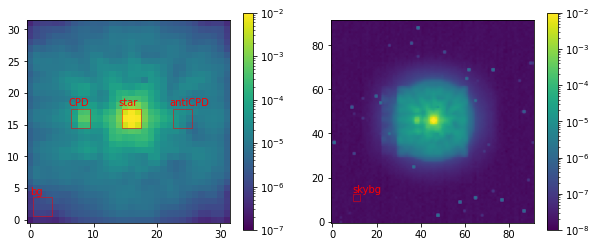

In [425]:
# Define apertures
import matplotlib.patches as patches
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
im1 = ax1.imshow(fluxJy, norm=LogNorm(vmin=1e-7,vmax=1e-2), origin="lower")
im2 = ax2.imshow(fluxwide, norm=LogNorm(vmin=1e-8,vmax=1e-2), origin="lower")
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

def draw(name, ax):
    origin, size = eval('o_'+name), eval('d_'+name)
    tup = (origin[0] - 0.5, origin[1] - 0.5)
    rec = patches.Rectangle(tup,size,size,linewidth=0.5,edgecolor='r',facecolor='none')
    ax.add_patch(rec)
    ax.text(origin[0]-1, origin[1]+size, name, fontsize=10, color='r')

draw('star', ax1) # an aperture on the star
draw('bg', ax1) # an aperture on the background
draw('CPD', ax1) # an aperture on the CPD
draw('antiCPD', ax1) # an aperture opposite to CPD
draw('skybg', ax2) # an aperture on the sky background

## Calculate flux within apertures

f_star:  0.07118331 Jy
f_CPD:  0.0022243785 Jy
std_bg: 3.5734448e-07
std_sky:  1.5523917e-09


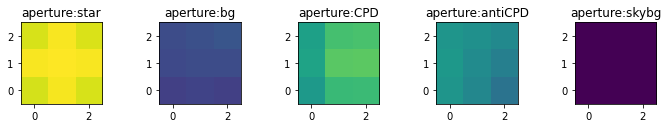

In [11]:
# Calculate flux of star
def plot_aperture(sub, name):
    plt.subplot(sub)
    ori, size = eval('o_'+name), eval('d_'+name)
    if name == 'skybg':
        ap = fluxwide[ori[1]:ori[1]+size, ori[0]:ori[0]+size]
    else:
        ap = fluxJy[ori[1]:ori[1]+size, ori[0]:ori[0]+size]
    plt.imshow(ap, norm=LogNorm(vmin=1e-7,vmax=1e-2), origin='lower')
    plt.title('aperture:'+name)
    return ap

plt.figure(figsize=(12,1.5))
star = plot_aperture(151, 'star')
bg = plot_aperture(152, 'bg')
CPD = plot_aperture(153, 'CPD')
antiCPD = plot_aperture(154, 'antiCPD')
skybg = plot_aperture(155, 'skybg')

f_star = star.sum()
f_bg = bg.sum()
f_star = f_star - f_bg

f_CPD = CPD.sum()
f_antiCPD = antiCPD.sum()
f_CPD = f_CPD - f_antiCPD

std_bg = bg.std()
std_skybg = skybg.std()

print("f_star: ", f_star, "Jy")
print("f_CPD: ", f_CPD, "Jy")
print("std_bg:", std_bg)
print("std_sky: ", std_skybg)